In [2]:
# Import the necessary packages
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [39]:
# Import the training and test data
training_df = pd.read_csv('train.csv')
real_validation_df = pd.read_csv('test.csv') # Vector of length N

# Retrieve the response and predictor (many) variables
X = training_df.drop('target', axis=1) 
Y = training_df['target']              

# Split the provided training sample in a training and validation set
# We do not use the actual validation sample, we make our own validation sample!
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

num_observations = X.shape[0]; num_columns = X.shape[1]
print(f'The number of observation is {num_observations} and the number of predictor variables in the training sample is: {num_columns}.')

The number of observation is 20132 and the number of predictor variables in the training sample is: 159.


In [41]:
# Initialize a XGBoost classifier model with a logistic binary objective function (default)
# The performance will be evaluated based on the error rate, number of incorrect predictions
# For a binary classification problem, the performance is typically evaluated using the error
# error = Fraction of incorrect predictions over the total number of predictions
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='error')

# Fitted XGBoost model, this variable is an instance of the XGBClassifier class
fitted_XGBoost_model = xgb_model.fit(X_train, Y_train)

In [42]:
# Get feature importance for different importance types
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

# Get the Booster object from the fitted XGBClassifier, in order to use the .get_score() command
booster_fitted_xgb = fitted_XGBoost_model.get_booster()

for imp_type in importance_types:
    # Get feature importance scores for each type
    feature_importance_dict = booster_fitted_xgb.get_score(importance_type=imp_type)

    # Convert the dictionary to a DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': list(feature_importance_dict.keys()),
        'Importance': list(feature_importance_dict.values())
    }).sort_values(by='Importance', ascending=False)
    
    # Print the feature with the highest importance for this type
    print(f"The feature with the highest {imp_type} score is {feature_importance_df.iloc[0, 0]} with score {feature_importance_df.iloc[0, 1]}.")

print(f'\nTake {importance_types[1]} for the type of importance metric.')

The feature with the highest weight score is age_ref with score 203.0.
The feature with the highest gain score is educa2_16.0 with score 37.606109619140625.
The feature with the highest cover score is educa2_16.0 with score 2300.931884765625.
The feature with the highest total_gain score is age_ref with score 1186.1605224609375.
The feature with the highest total_cover score is fdhomepq with score 48393.33984375.

Take gain for the type of importance metric.


The feature with the highest gain score is educa2_16.0 with gain 37.606109619140625.


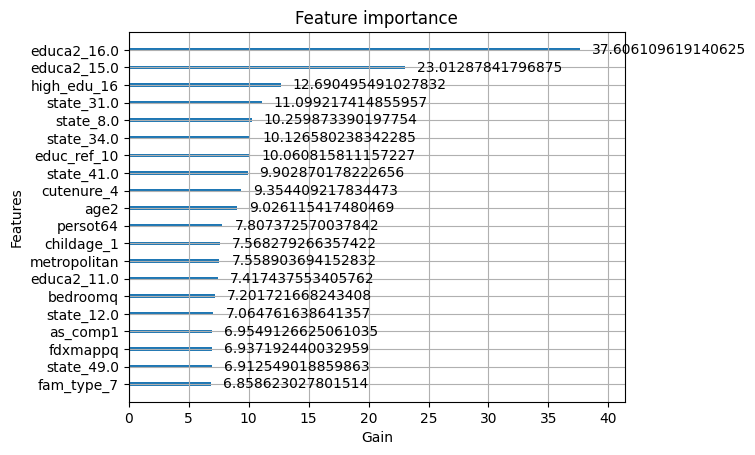

In [43]:
# Feature selection, based on the F-score of each feature in the XGBoost
# Plot the F-score of each variable
importance_type_choice = 'gain'
xgb.plot_importance(fitted_XGBoost_model, ylabel = 'Features', xlabel = 'Gain', max_num_features=20, importance_type=importance_type_choice)

# Get feature importance scores
feature_importance_dict = booster_fitted_xgb.get_score(importance_type=importance_type_choice)

# Convert the dictionary to a DataFrame
feature_importance_gain_df = pd.DataFrame({
    'Feature': list(feature_importance_dict.keys()),
    'Importance': list(feature_importance_dict.values())}).sort_values(by='Importance', ascending=False)

# Print the feature with the highest gain score
print(f'The feature with the highest gain score is {feature_importance_gain_df.iloc[0, 0]} with gain {feature_importance_gain_df.iloc[0, 1]}.')

In [44]:
# Take the top 100 most used predictors used in the decision trees
selectedFeatures = 100
top_features = feature_importance_gain_df['Feature'].head(selectedFeatures).values 

# Create a new training and validation set with only the top 'selectedFeatures' features
X_train_top_features = X_train[top_features]
X_val_top_features = X_val[top_features]

In [47]:
# Tuning hyperparameters through k-fold cross validation (lecture 1, slide 36)
# Select the optimal values of the parameters based on prediction performance on the validation set
# Initialize a dictionary for the extensive parameter grid
param_grid = {
    'n_estimators': [50, 100],                   # Number of trees
    'max_depth': [5, 120, 15],                # Maximum depth of trees
    'learning_rate': [0.10, 0.15, 0.20],     # Learning rate
    'subsample': [0.60, 0.80, 1.0],           # Subsampling ratio
    'colsample_bytree': [0.6, 0.8, 1.0],    # Feature sampling ratio
    'min_child_weight': [1, 3, 5],          # Minimum child weight
    'gamma': [0, 0.1],                 # Minimum loss reduction
    'reg_alpha': [0.1, 0.5],               # L1 regularization
    'reg_lambda': [0.1, 0.5]                  # L2 regularization
}   

# Calculate the total number of combinations
total_combinations = 1
for key, values in param_grid.items():
    total_combinations *= len(values)
print(f'The total number of combinations of the parameters is {total_combinations}.')

The total number of combinations of the parameters is 3888.


In [ ]:
# Declare a grid_search class instance
# The scoring parameter determines the metric used to evaluate the model’s performance during the cross-validation process. 
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=6, scoring='accuracy', verbose=0)

# For each hyperparameter combination, it trains the model using XGBoost and k-fold cross-validation
grid_search.fit(X_train_top_features, Y_train) 

In [36]:
# The best hyperparameter combination is based on the highest cross-validated accuracy
# We make a new XGBoostClassifier object, containing the optimized hyperparameters
best_XGBoost_model = grid_search.best_estimator_

# Make predictions on the validation set
y_val_pred = best_XGBoost_model.predict(X_val_top_features)

# Calculate validation accuracy
validation_accuracy = accuracy_score(Y_val, y_val_pred)
print(f'Validation Accuracy: {validation_accuracy:.4f}')

# Print classification report with zero_division handling to avoid warnings
print('\nValidation Classification Report:')
print(classification_report(Y_val, y_val_pred, zero_division=0))

# Generate the confusion matrix using a new variable name 'cm'
cm = confusion_matrix(Y_val, y_val_pred)

# Define row and column names (replace 'Class 1', 'Class 2', etc., with actual class names if available)
class_names = ['40th-60th', 'Outside']

# Create a DataFrame for the confusion matrix with shorter row and column labels
cm_df = pd.DataFrame(cm, index=[f'Actual {name}' for name in class_names], columns=[f'Predicted {name}' for name in class_names])

# Print the confusion matrix with labels
print('\nValidation Confusion Matrix:')
print(cm_df)

Validation Accuracy: 0.8314

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      3154
           1       0.75      0.33      0.46       873

    accuracy                           0.83      4027
   macro avg       0.80      0.65      0.68      4027
weighted avg       0.82      0.83      0.80      4027


Validation Confusion Matrix:
                  Predicted 40th-60th  Predicted Outside
Actual 40th-60th                 3059                 95
Actual Outside                    584                289


In [12]:
# Step 1: Retrieve the optimized hyperparameters from the best estimator
optimized_params = best_XGBoost_model.get_params()
def print_non_none_params(params):
    print("Optimized Hyperparameters (non-None values):")
    for this, value in params.items():
        if value is not None:
            print(f"{this}: {value}")

# Assuming optimized_params is already defined
print_non_none_params(optimized_params)

# Step 2: Concatenate the training and validation data
X_combined_top_features = pd.concat([X_train_top_features, X_val_top_features], axis=0)
Y_combined = pd.concat([Y_train, Y_val], axis=0)

# Step 3: Initialize a new XGBoost model using the retrieved optimized hyperparameters
# Note: We exclude some parameters like 'objective' and 'eval_metric' if needed
xgb_model_retrained = xgb.XGBClassifier(**optimized_params)

# Step 4: Retrain the model using the combined training and validation data
xgb_model_retrained.fit(X_combined_top_features, Y_combined)

# Step 5: Now you can evaluate or use the retrained model
# For example, making predictions on a test set:
X_test_top_features = real_validation_df[top_features]
Y_test_pred = xgb_model_retrained.predict(X_test_top_features)

Optimized Hyperparameters (non-None values):
objective: binary:logistic
colsample_bytree: 0.8
enable_categorical: False
eval_metric: error
gamma: 0
learning_rate: 0.15
max_depth: 15
min_child_weight: 1
missing: nan
n_estimators: 100
reg_alpha: 0.1
reg_lambda: 0.5
subsample: 0.8


In [18]:
y_test_pred = xgb_model_retrained.predict(X_test_top_features)
pres = y_test_pred.tolist()
single_line = ' '.join(map(str, pres))

# Save to file
with open('predictions.txt', 'w') as f:
    f.write(single_line)

print('Predictions have been saved to predictions.txt.')

Predictions have been saved to predictions.txt.
